In [176]:
import geopandas as gpd
import pandas as pd
import geemap
import ee
import shapely
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
ee.Authenticate()
ee.Initialize()

Planificación General: Medir área total de la laguna a lo largo del tiempo -> hacer un área total del uso de suelo usando aquella red neuronal que clasificaba segun crop o algo asi -> Ver como avanzó crop e industrial a lo largo del tiempo.

### Definimos como aoi un área de aproximadamente 5km alrededor de la Laguna de Aculeo, y el intervalo de tiempo de interés 2014-2024 ya que se secó alrededor de 2018, Además de la disponibilidad de landsat 8, que comienza en 2013

In [69]:
doi = ["2014-01-01","2024-01-01"]
doi_intervalar = []
for i in range(14,25):
    for j in range(1,13):
        if i == 24 and j >= 6:
            break
        doi_intervalar.append(str(2000+i)+ "-" +  str(j)+ "-01")
doi_intervalar

['2014-1-01',
 '2014-2-01',
 '2014-3-01',
 '2014-4-01',
 '2014-5-01',
 '2014-6-01',
 '2014-7-01',
 '2014-8-01',
 '2014-9-01',
 '2014-10-01',
 '2014-11-01',
 '2014-12-01',
 '2015-1-01',
 '2015-2-01',
 '2015-3-01',
 '2015-4-01',
 '2015-5-01',
 '2015-6-01',
 '2015-7-01',
 '2015-8-01',
 '2015-9-01',
 '2015-10-01',
 '2015-11-01',
 '2015-12-01',
 '2016-1-01',
 '2016-2-01',
 '2016-3-01',
 '2016-4-01',
 '2016-5-01',
 '2016-6-01',
 '2016-7-01',
 '2016-8-01',
 '2016-9-01',
 '2016-10-01',
 '2016-11-01',
 '2016-12-01',
 '2017-1-01',
 '2017-2-01',
 '2017-3-01',
 '2017-4-01',
 '2017-5-01',
 '2017-6-01',
 '2017-7-01',
 '2017-8-01',
 '2017-9-01',
 '2017-10-01',
 '2017-11-01',
 '2017-12-01',
 '2018-1-01',
 '2018-2-01',
 '2018-3-01',
 '2018-4-01',
 '2018-5-01',
 '2018-6-01',
 '2018-7-01',
 '2018-8-01',
 '2018-9-01',
 '2018-10-01',
 '2018-11-01',
 '2018-12-01',
 '2019-1-01',
 '2019-2-01',
 '2019-3-01',
 '2019-4-01',
 '2019-5-01',
 '2019-6-01',
 '2019-7-01',
 '2019-8-01',
 '2019-9-01',
 '2019-10-01',
 '20

In [70]:
# aoi = gpd.GeoSeries(shapely.Point(),crs="EPSG:4326").to_crs("EPSG:32719")
aoi = ee.Geometry.Point([-70.91725911612781,-33.84565081436696]).buffer(5000)
# aoi_bbox = ee.Geometry.Polygon(json.loads(aoi)['features'][0]['geometry']['coordinates'], 'EPSG:4326')

m = geemap.Map(center=[-33.84565081436696, -70.91725911612781], zoom=15)

m.addLayer(aoi,name='aoi')
m

Map(center=[-33.84565081436696, -70.91725911612781], controls=(WidgetControl(options=['position', 'transparent…

In [71]:
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  #thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True)

In [139]:
# Map = geemap.Map(center=[-33.84565081436696, -70.91725911612781],zoom=12)

# NDWI usado: http://archive.eclass.uth.gr/eclass/modules/document/file.php/MHXC241/PROJECT/Mc_Feeters_NDWI_01431169608948714.pdf

imagenes_ndwi = []
fechas_con_imagen = []
for i in range(len(doi_intervalar)-1):
    inicio = doi_intervalar[i]
    fin = doi_intervalar[i+1]
    print(inicio, fin)
# Obtenemos imágenes
    landsat_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filter(ee.Filter.lessThan(leftField="CLOUD_COVER_LAND", rightValue=20)).filterDate(inicio,fin).filterBounds(aoi).select(['SR_B3', 'SR_B5'])
# Hacemos escalamientos correspondientes
    landsat_collection = landsat_collection.map(apply_scale_factors)
# Obtenemos geomediana para reducir a una imágen
    try: # Si no hay ninguna imágen para ese mes, esta siguiente linea dará error, por lo que esta linea lo maneja (de forma un poco bruta, pero funciona)
        r = ee.Reducer.geometricMedian(2).setOutputs(["geom_" + nombre for nombre in landsat_collection.first().bandNames().getInfo()])
    except:
        print("Colección Vacía")
        continue
    geomediana = landsat_collection.reduce(r)
#Calculamos ndwi
    ndwi = geomediana.normalizedDifference(["geom_SR_B3","geom_SR_B5"])
    geomediana = geomediana.addBands(ndwi)
# Agregamos a la lista
    imagenes_ndwi.append(geomediana)
    fechas_con_imagen.append(inicio) # Guardamos las fechas para después

ndwis = ee.ImageCollection.fromImages(imagenes_ndwi)




2014-1-01 2014-2-01
2014-2-01 2014-3-01
2014-3-01 2014-4-01
Colección Vacía
2014-4-01 2014-5-01
2014-5-01 2014-6-01
Colección Vacía
2014-6-01 2014-7-01
2014-7-01 2014-8-01
Colección Vacía
2014-8-01 2014-9-01
2014-9-01 2014-10-01
Colección Vacía
2014-10-01 2014-11-01
2014-11-01 2014-12-01
2014-12-01 2015-1-01
Colección Vacía
2015-1-01 2015-2-01
2015-2-01 2015-3-01
2015-3-01 2015-4-01
2015-4-01 2015-5-01
2015-5-01 2015-6-01
2015-6-01 2015-7-01
Colección Vacía
2015-7-01 2015-8-01
2015-8-01 2015-9-01
Colección Vacía
2015-9-01 2015-10-01
Colección Vacía
2015-10-01 2015-11-01
2015-11-01 2015-12-01
2015-12-01 2016-1-01
2016-1-01 2016-2-01
2016-2-01 2016-3-01
Colección Vacía
2016-3-01 2016-4-01
2016-4-01 2016-5-01
2016-5-01 2016-6-01
2016-6-01 2016-7-01
2016-7-01 2016-8-01
Colección Vacía
2016-8-01 2016-9-01
2016-9-01 2016-10-01
2016-10-01 2016-11-01
2016-11-01 2016-12-01
2016-12-01 2017-1-01
Colección Vacía
2017-1-01 2017-2-01
2017-2-01 2017-3-01
2017-3-01 2017-4-01
2017-4-01 2017-5-01
Colecc

In [93]:

videoArgs = {'dimensions': 500,
             'region': aoi,
             'framesPerSecond': 5,
            'bands': ["nd"], "palette":["green", "blue"]}

## Cambios: Mejor calcular todas los ndwi y hacer un video de eso yo creo
print(ndwis.getVideoThumbURL(videoArgs))
print(ndwis.getFilmstripThumbURL(videoArgs))

https://earthengine.googleapis.com/v1/projects/earthengine-legacy/videoThumbnails/bf98445f764c09ac05ee4cf85a7197f9-84f217c4e7dfde61984502d88cf77994:getPixels
https://earthengine.googleapis.com/v1/projects/earthengine-legacy/filmstripThumbnails/de021fd734342992f292f6f16f84e328-644e649a8aaa2c9a816c287eb26ca7b8:getPixels


### Casualmente obtenemos 100 imaǵenes de meses tales que tuvieron al menos una imágen con una cobertura aceptable de nubes, para la que calculamos la geomediana de las bandas, y luego obtuvimos el ndwi, ahora buscamos obtener el area total de agua para cada imágen.

In [113]:
imagenes_binarias = [] #Imágenes binarias con píxeles diciendo si ese pixel tiene o no agua
for ndwi in imagenes_ndwi: # ndwi es una imágen que contiene 3 bandas, siendo una de estas ndwi
    imagenes_binarias.append(ndwi.gt(0.3).selfMask()) # Guardamos las imágenes de forma binaria

imagenes_binarias[0]

In [120]:
m = geemap.Map(center=[-33.84565081436696, -70.91725911612781], zoom=15)
vis = {
    'bands': ['nd']
}


m.addLayer(aoi,name='aoi')
m.addLayer(imagenes_binarias[0].clip(aoi), vis,name='agua')

m

Map(center=[-33.84565081436696, -70.91725911612781], controls=(WidgetControl(options=['position', 'transparent…

In [127]:
# Este segmento de código saca el área para cada imágen
areas = []
for imagen_binaria in imagenes_binarias:
    pixelarea = ee.Image.pixelArea()
    flood_extent2 = pixelarea.updateMask(imagen_binaria.select("nd"))
    suma = flood_extent2.reduceRegion(ee.Reducer.sum(), aoi, scale=30)
    suma = suma.getNumber('area').getInfo()# en metros cuadrados
    square_meters = suma
    square_kilometers = square_meters / (1e6)
    areas.append((square_meters,square_kilometers))

areas[0:5]
    

[(5646227.292114258, 5.646227292114258),
 (7319313.66809082, 7.31931366809082),
 (5105671.21484375, 5.10567121484375),
 (7210462.703491211, 7.210462703491211),
 (7162003.768676758, 7.162003768676758)]

In [155]:
df = pd.DataFrame(areas, columns=["m", "km"])
df["fecha"] = fechas_con_imagen
df["año"] = df["fecha"].map(lambda x: (x.split("-")[0]))
df["mes"] = df["fecha"].map(lambda x: (x.split("-")[1]))
df

,m,km,fecha,año,mes
0,5.646227e+06,5.646227,2014-1-01,2014,1
1,7.319314e+06,7.319314,2014-2-01,2014,2
2,5.105671e+06,5.105671,2014-4-01,2014,4
3,7.210463e+06,7.210463,2014-6-01,2014,6
4,7.162004e+06,7.162004,2014-8-01,2014,8
...,...,...,...,...,...
95,5.040128e+06,5.040128,2023-12-01,2023,12
96,4.727712e+06,4.727712,2024-1-01,2024,1
97,4.030591e+06,4.030591,2024-2-01,2024,2
98,2.138354e+06,2.138354,2024-3-01,2024,3


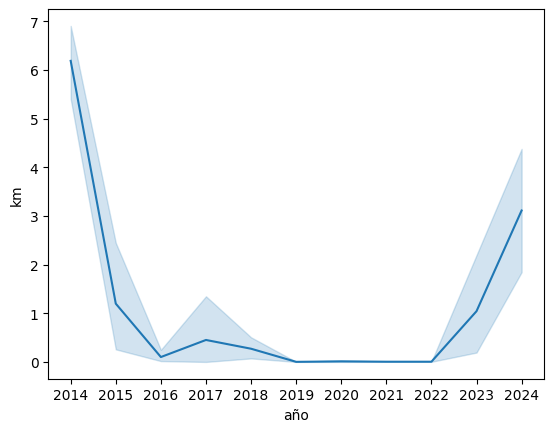

In [160]:

plot = sns.lineplot(y=df["km"], x=df["año"])
fig = plot.get_figure()
fig.savefig("visualizaciones/area_segun_tiempo.png") 

fig. 1 área de la laguna aculeo a lo largo del tiempo.

In [166]:
lluvias = pd.read_csv("data/suma_anual_precip.csv")
lluvias.head()


,sum_precip,año
0,16.7,2019
1,48.8,2020
2,12.8,2021
3,116.0,2022
4,347.8,2023


<Axes: xlabel='año', ylabel='sum_precip'>

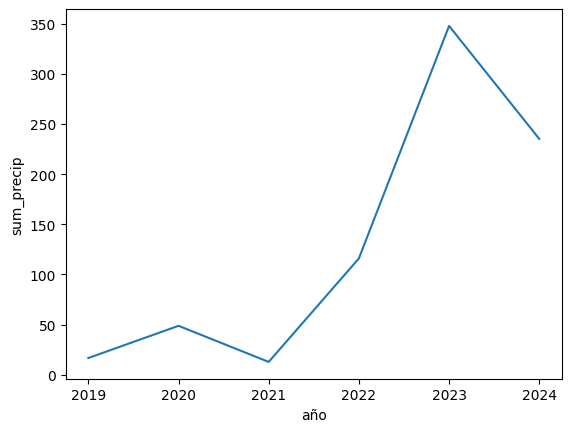

In [167]:
sns.lineplot(lluvias,x="año",y="sum_precip")

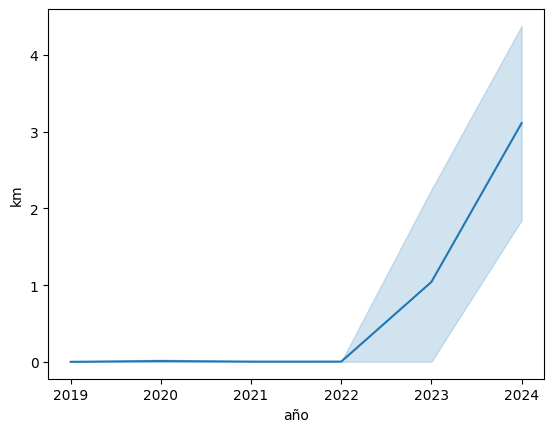

In [174]:
df_p = df.astype({"año":int})
df_p = df_p[df_p["año"] >= 2019] #Acotamos el dataframe del área de la laguna aculeo para compararlo con los datos de lluvias

plot = sns.lineplot(y=df_p["km"], x=df_p["año"])

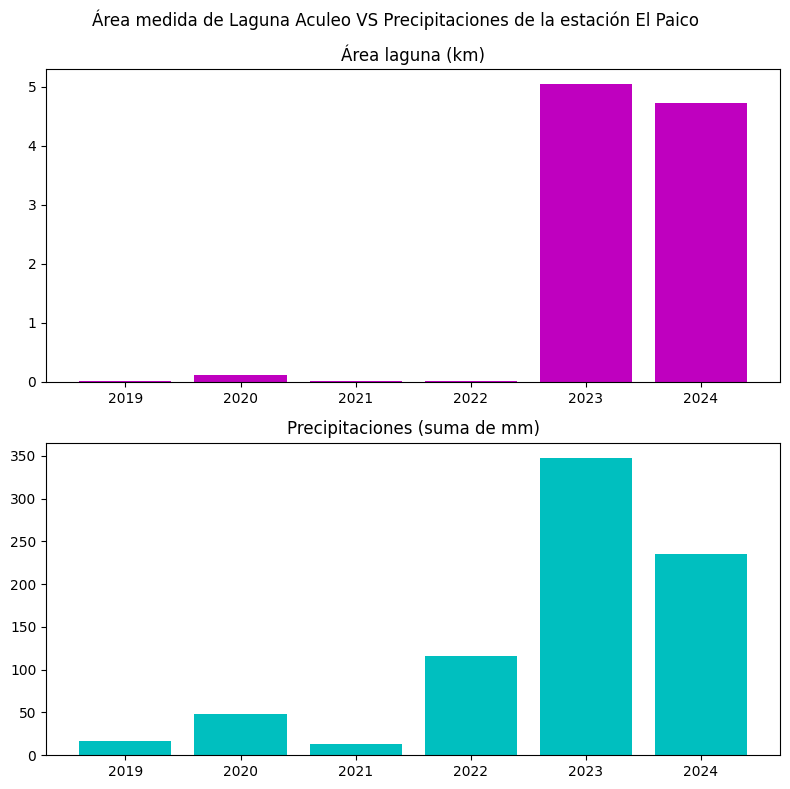

In [182]:
fig, ax = plt.subplots(2, figsize=(8,8))
ax[0].ticklabel_format(style='plain')
ax[0].set_title("Área laguna (km)")
ax[1].set_title("Precipitaciones (suma de mm)")
ax[0].bar(df_p["año"], df_p["km"], color='m')
ax[1].bar(lluvias["año"],lluvias["sum_precip"] , color='c')
fig.suptitle(f"Área medida de Laguna Aculeo VS Precipitaciones de la estación El Paico")
fig.tight_layout()
    # plt.savefig(f"Graficos\\{date.today()}.jpg", dpi="figure", format="jpg")

fig. 2 Área medida de Laguna Aculeo VS Precipitaciones de la estación El Paico

### Dado la limitación del _scope_ de este análisis, tales como que hay meses sin datos en precipitaciones, y meses sin datos satelitales, sólo podemos hacer el análisis de forma anual, de todas maneras se encuentra una suerte de correlación entre la lluvia y el área, verificando la hipótesis de que la laguna se secó dada la sequía que se está viviendo.